In [1]:
import sys
import torch
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torchvision.transforms as transforms
sys.path.insert(0, './dinov2')
device = "cuda:0"

In [2]:
dinov2_transform = transforms.Compose([
    transforms.Resize(256, interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Original Model

In [3]:
original_model = torch.hub.load('dinov2/', 'dinov2_vitl14', source = "local").cuda()

/home/nickj/vit_register_neurons/dinov2/dinov2/layers/swiglu_ffn.py:48: UserWarning: xFormers is disabled (SwiGLU)
  warnings.warn("xFormers is disabled (SwiGLU)")
/home/nickj/vit_register_neurons/dinov2/dinov2/layers/swiglu_ffn.py:54: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/home/nickj/vit_register_neurons/dinov2/dinov2/layers/attention.py:30: UserWarning: xFormers is disabled (Attention)
  warnings.warn("xFormers is disabled (Attention)")
/home/nickj/vit_register_neurons/dinov2/dinov2/layers/attention.py:34: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/home/nickj/vit_register_neurons/dinov2/dinov2/layers/block.py:36: UserWarning: xFormers is disabled (Block)
  warnings.warn("xFormers is disabled (Block)")
/home/nickj/vit_register_neurons/dinov2/dinov2/layers/block.py:41: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available 

(-0.5, 223.5, 223.5, -0.5)

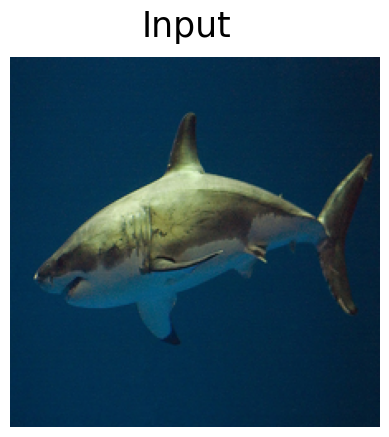

In [4]:
im = Image.open("images/shark.JPEG").resize((224,224))
plt.imshow(im)
plt.suptitle("Input", fontsize = 25)
plt.axis("off")

In [5]:
image = dinov2_transform(im).unsqueeze(0).to(device)

In [6]:
attn_out = {}
def hook_attn(module, input, output):
    attn_out[-1] = output

patch_out = {}
def hook_patch(module, input, output):
    patch_out[-1] = output

original_model._modules["blocks"][-1].attn.post_softmax_identity.register_forward_hook(hook_attn)
original_model._modules["blocks"][-1].register_forward_hook(hook_patch)

_ = original_model(image)

In [8]:
attns = attn_out[-1]
patches = patch_out[-1]

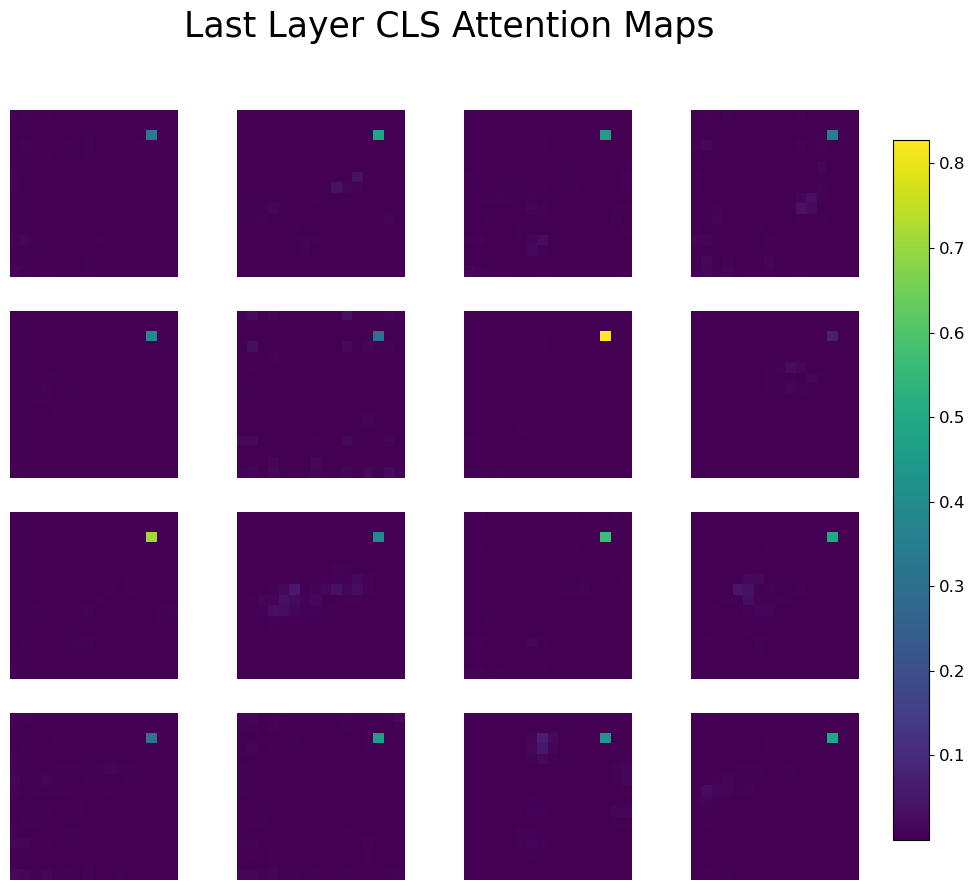

In [9]:
maps = attns[-1].float().squeeze(0).detach().cpu().numpy()
fig, axes = plt.subplots(4, 4, figsize=(12, 10))
axes = axes.flatten()

# Find the global min and max for consistent color scaling
vmin = maps[:, 0, 1:].min()
vmax = maps[:, 0, 1:].max()

for i in range(16):
    im = axes[i].imshow(maps[i][0, 1:].reshape(16,16), vmin=vmin, vmax=vmax)
    axes[i].axis('off')

plt.suptitle("Last Layer CLS Attention Maps", fontsize=25)


plt.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.87, 0.15, 0.03, 0.7])
cbar = plt.colorbar(im, cax=cbar_ax)
cbar.ax.tick_params(labelsize=12)

plt.show()

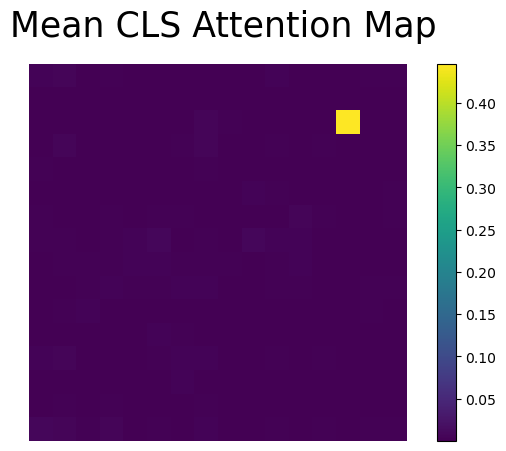

In [10]:
mean_map = attns[-1].float().squeeze(0).mean(0).detach().cpu().numpy()
im = plt.imshow(mean_map[0, 1:].reshape(16,16))
plt.suptitle("Mean CLS Attention Map", fontsize = 25)
plt.tight_layout()
plt.axis("off")
plt.colorbar(im)
plt.show()


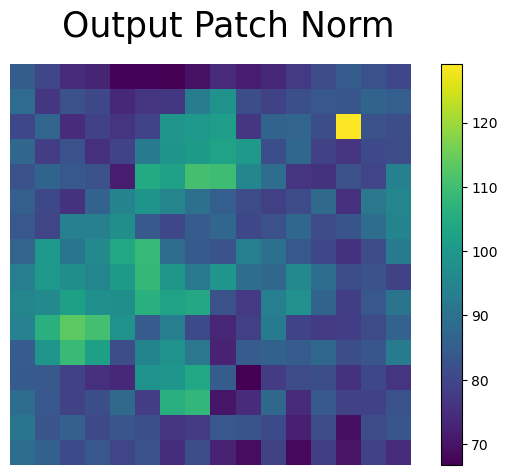

In [11]:
patch_norms = torch.norm(patch_out[-1].float().squeeze(0), dim=-1).detach().cpu().numpy()

plt.axis('off')
plt.suptitle("Output Patch Norm", fontsize=25)

im = plt.imshow(patch_norms[1:].reshape(16,16))
plt.colorbar(im)

plt.tight_layout()
plt.show()

# Model with test-time register

In [12]:
model = torch.hub.load('dinov2/', 'dinov2_vitl14_tt_reg', source="local").cuda()

# Alternatively, you can load from github without installing our repo locally
# model = torch.hub.load('nickjiang2378/test-time-registers/dinov2/', 'dinov2_vitl14_tt_reg')

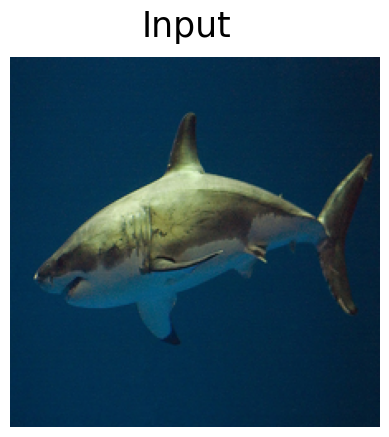

In [19]:
im = Image.open("images/shark.JPEG").resize((224,224))
plt.imshow(im)
plt.suptitle("Input", fontsize = 25)
plt.axis("off")

image = dinov2_transform(im).unsqueeze(0).to(device)

In [20]:
attn_out = {}
def hook_attn(module, input, output):
    attn_out[-1] = output

patch_out = {}
def hook_patch(module, input, output):
    patch_out[-1] = output

model._modules["blocks"][-1].attn.post_softmax_identity.register_forward_hook(hook_attn)
model._modules["blocks"][-1].register_forward_hook(hook_patch)

_ = model(image)

In [21]:
attns = attn_out[-1]
patches = patch_out[-1]

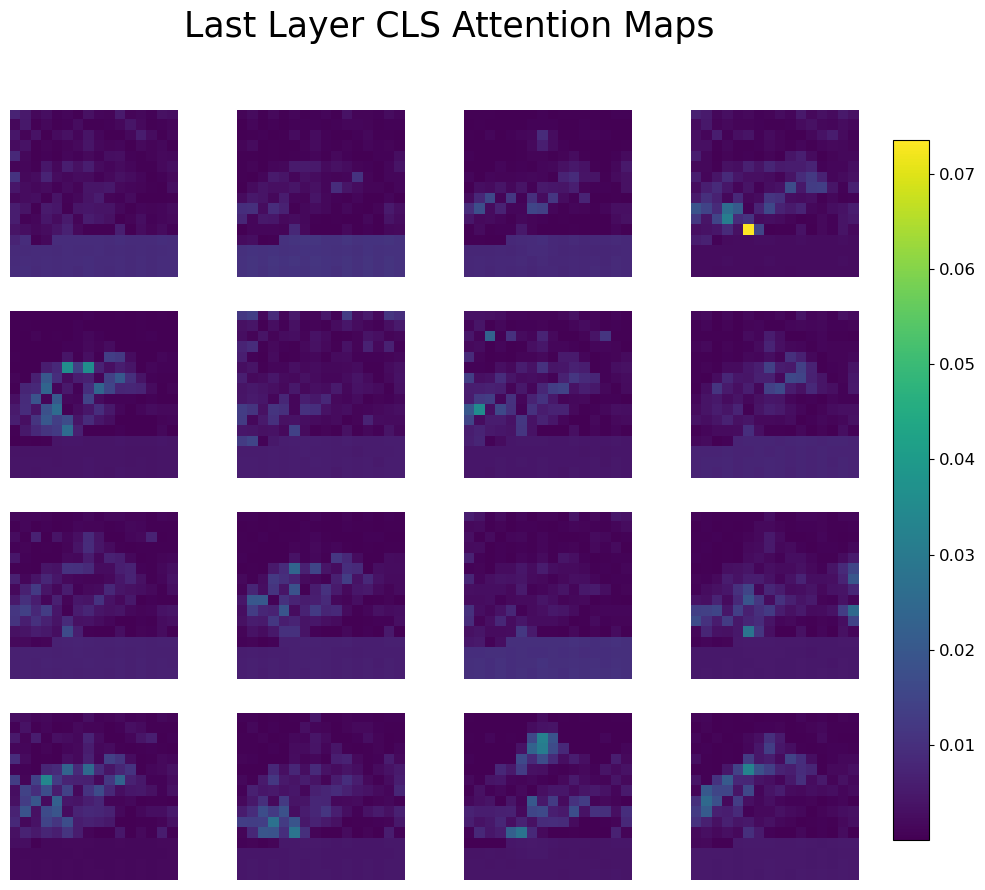

In [22]:
maps = attns[-1].float().squeeze(0).detach().cpu().numpy()
fig, axes = plt.subplots(4, 4, figsize=(12, 10))
axes = axes.flatten()

# Find the global min and max for consistent color scaling
vmin = maps[:, 0, 1:-1].min()
vmax = maps[:, 0, 1:-1].max()

for i in range(16):
    im = axes[i].imshow(maps[i][0, 1:-1].reshape(16,16), vmin=vmin, vmax=vmax)
    axes[i].axis('off')

plt.suptitle("Last Layer CLS Attention Maps", fontsize=25)


plt.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.87, 0.15, 0.03, 0.7])
cbar = plt.colorbar(im, cax=cbar_ax)
cbar.ax.tick_params(labelsize=12)

plt.show()

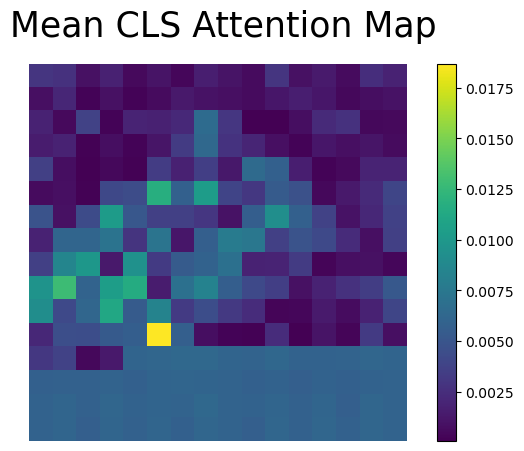

In [23]:
mean_map = attns[-1].float().squeeze(0).mean(0).detach().cpu().numpy()
im = plt.imshow(mean_map[0, 1:-1].reshape(16,16))
plt.suptitle("Mean CLS Attention Map", fontsize = 25)
plt.tight_layout()
plt.axis("off")
plt.colorbar(im)
plt.show()


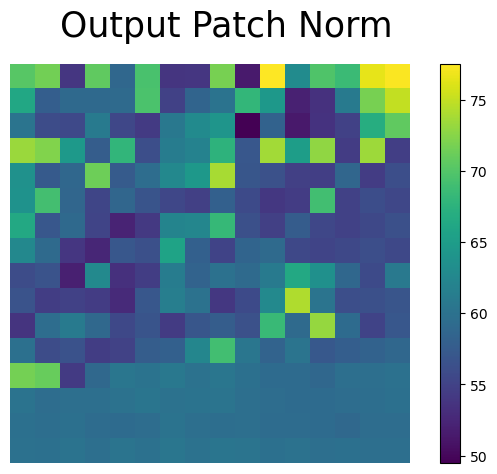

In [24]:
patch_norms = torch.norm(patch_out[-1].float().squeeze(0), dim=-1).detach().cpu().numpy()

plt.axis('off')
plt.suptitle("Output Patch Norm", fontsize=25)

im = plt.imshow(patch_norms[1:-1].reshape(16,16))
plt.colorbar(im)

plt.tight_layout()
plt.show()